In [1]:
# Magic line to force reload all modules when this cell is run multiple times
%load_ext autoreload
%autoreload 2

from ClusterPipeline import ClusterPipeline
# from common_imports import *
from helper import simulate_blobs
from helper import plot_confusion_matrix

import numpy as np
import pandas as pd

/Users/Work/anaconda3/envs/condatensor/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/Users/Work/anaconda3/envs/condatensor/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
def exp_decay(epoch):
    initial_lr = 0.1
    decay_steps = 50
    decay_rate = 0.1
    
    decayed_lr =  initial_lr * np.power(decay_rate, (epoch/decay_steps))
#     print("New Learning Rate:", decayed_lr)
    return decayed_lr

def build_dnn(num_features, num_nodes = 16, depth = 2, num_labels=2, activation = "elu"):
    
    import tensorflow as tf
    import keras
    from keras import optimizers
    from keras import regularizers
    keras.backend.clear_session()
    
    reg_scale = 0.001 # For L1 Reg
    my_reg = regularizers.l1_l2(reg_scale) # Can change this if needed
    
    dnn = keras.models.Sequential()

    Dense = keras.layers.Dense

    # Using He initialization
    he_init = keras.initializers.he_normal()
    

    dnn.add(Dense(units = 100, activation="elu", input_dim=num_features,
                  kernel_initializer=he_init, kernel_regularizer = my_reg))
    dnn.add(keras.layers.Dropout(0.5))
    dnn.add(Dense(units = 50, activation="elu",
                  kernel_initializer=he_init, kernel_regularizer = my_reg))
    dnn.add(keras.layers.Dropout(0.5))
    dnn.add(Dense(units=25, activation='elu',
                  kernel_initializer=he_init, kernel_regularizer = my_reg))
    dnn.add(keras.layers.Dropout(0.5))
    
    dnn.add(Dense(units=num_labels, activation="softmax",
                  kernel_initializer=he_init, kernel_regularizer = my_reg)) # 5 labels -> logits for now
    
#     nadam = keras.optimizers.Nadam()
    NSGD = keras.optimizers.SGD(lr=0.01,momentum=0.9,nesterov=True)
    
    dnn.compile(loss='categorical_crossentropy',
                  optimizer=NSGD,
                  metrics=['accuracy'])
    
    return dnn

In [3]:
raw_data = pd.read_csv("data/ADNI_CN_AD.csv", index_col=0)
original_data = raw_data.drop(columns=["label"])
raw_labels = raw_data["label"]
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76 entries, 2 to 142
Columns: 149 entries, G_and_S_frontomargin_TH_lh to label
dtypes: float64(148), object(1)
memory usage: 89.1+ KB


In [4]:
from sklearn.preprocessing import OrdinalEncoder
oe = OrdinalEncoder(dtype=int)
training_labels = np.ravel(oe.fit_transform(raw_labels.values.reshape(-1,1)))
training_labels = pd.Series(training_labels)
oe.categories_

[array(['AD', 'CN'], dtype=object)]

In [5]:
raw_labels.value_counts()

CN    50
AD    26
Name: label, dtype: int64

In [6]:
# pd.DataFrame(training_labels)
nn = build_dnn(num_features=original_data.shape[1])
nn.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               14900     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 25)                1275      
_________________________________________________________________
dropout_3 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 52        
Total para

In [7]:
def get_split_index(features, labels, test_size=0.1):
    import numpy as np
    from sklearn.model_selection import StratifiedShuffleSplit
    
    features = np.array(features)
    # The train set will have equal amounts of each target class
    # Performing single split
    split = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=42)
    return [[train_index, test_index] for train_index,test_index in split.split(features, labels)]

def split_valid(features, training_labels, valid_size=0.5):
    train_index, validation_index = get_split_index(features, training_labels, test_size=valid_size)[0]
    
    X_valid, y_valid = features.iloc[validation_index], training_labels.iloc[validation_index]
    X_train, y_train = features.iloc[train_index], training_labels.iloc[train_index]
     
    return X_train, y_train, X_valid, y_valid

In [15]:
if __name__ == "__main__":

    # Separating a hold out set that will be used for validation later
    X_train, y_train, X_valid, y_valid = split_valid(original_data, training_labels, valid_size=0.1)    

    pipeline = ClusterPipeline(nn, [X_train, y_train], [X_valid,y_valid])
    
    pipeline.train_model(batch_size=10,epochs=150, cross_validation=True, parallel=False, verbose=0)

Epoch 1/150
90/90 [==============================] - 0s 133us/step - loss: 0.1906 - acc: 1.0000
Epoch 2/150
90/90 [==============================] - 0s 138us/step - loss: 0.1844 - acc: 1.0000
Epoch 3/150
90/90 [==============================] - 0s 177us/step - loss: 0.1859 - acc: 1.0000
Epoch 4/150
90/90 [==============================] - 0s 159us/step - loss: 0.1818 - acc: 1.0000
Epoch 5/150
90/90 [==============================] - 0s 157us/step - loss: 0.1810 - acc: 1.0000
Epoch 6/150
90/90 [==============================] - 0s 155us/step - loss: 0.1887 - acc: 0.9889
Epoch 7/150
90/90 [==============================] - 0s 141us/step - loss: 0.1826 - acc: 1.0000
Epoch 8/150
90/90 [==============================] - 0s 164us/step - loss: 0.1835 - acc: 1.0000
Epoch 9/150
90/90 [==============================] - 0s 175us/step - loss: 0.1822 - acc: 1.0000
Epoch 10/150
90/90 [==============================] - 0s 161us/step - loss: 0.1807 - acc: 1.0000
Epoch 11/150
90/90 [===================

Correct: 56
Test Size: 68

In [9]:
# [True,True,False].count(True)
# np.array([True,True,False, True, False]).sum()
plot_confusion_matrix(y_train.values[pipeline.testing_idxs], pipeline.predictions, oe.categories_[0])

IndexError: arrays used as indices must be of integer (or boolean) type

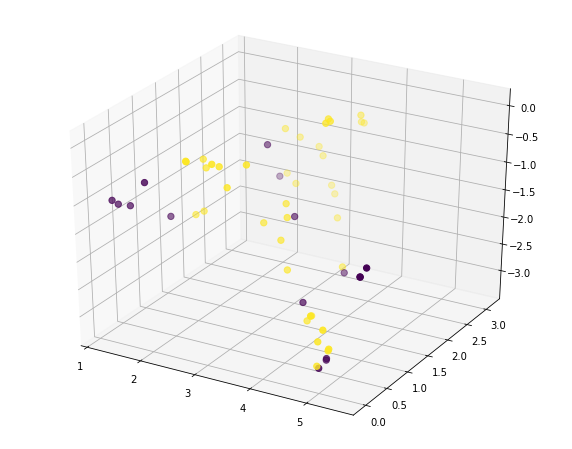

In [35]:
# %matplotlib notebook
import umap
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D

reducer = umap.UMAP(random_state=42,
                    n_components = 3,
                    n_neighbors=3,
                    min_dist=0)
embedding = reducer.fit_transform(pipeline.lrp_results)

# fig = plt.figure(figsize=(12,10))
# plt.scatter(x=embedding[:,0], y=embedding[:,1], s= 30)
# plt.colorbar()

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
# ax.scatter(embedding[:,0], embedding[:,1], embedding[:,2], s=40)

ax.scatter(*embedding.T, s=40, c=y_train.values[pipeline.testing_idxs][pipeline.correct_preds_bool_arr])

plt.show()

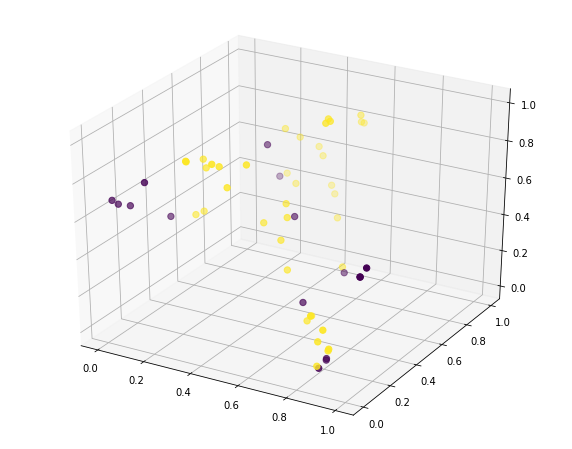

In [39]:
from sklearn.preprocessing import MinMaxScaler

s_embedding = MinMaxScaler().fit_transform(embedding)

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(*s_embedding.T, s=40, c=y_train.values[pipeline.testing_idxs][pipeline.correct_preds_bool_arr])

plt.show()

## Running HDBSCAN on 3D embedding

In [37]:
import hdbscan

min_cluster_sizes=range(3,20,1)
scores = pipeline.clusterPerf(embedding, [], min_cluster_sizes)
minsize = int(scores["Halkidi-Filtered Noise"].idxmin())
print("Minsize:", minsize)
scores["Halkidi-Filtered Noise"][minsize]
scores

Minsize: 3


,Clusters,Noise,Silhouette,Halkidi,Halkidi-Filtered Noise,Halkidi-Bounded Noise
3,5,0.181818,3.541985e-01,4.529926e-01,2.885900e-01,3.964673e-01
4,4,0.236364,2.946373e-01,5.155226e-01,3.269384e-01,5.039199e-01
5,3,0.345455,2.214081e-01,8.338791e-01,4.781614e-01,1.051661e+00
6,3,0.418182,1.990990e-01,7.291536e-01,3.698445e-01,1.050911e+00
7,3,0.454545,1.959139e-01,6.457605e-01,3.731903e-01,7.529575e-01
8,2,0.418182,1.542383e-01,1.055620e+00,9.644491e-01,1.949664e+00
9,2,0.509091,1.327813e-01,1.023316e+00,1.191514e+00,2.226971e+00
10,2,0.509091,1.059272e-01,1.034349e+00,1.206607e+00,1.949664e+00
11,2,0.418182,1.471277e-01,1.001274e+00,8.619770e-01,1.372387e+00
12,0,1.000000,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09


In [38]:
min_cluster_sizes=range(3,20,1)
scores = pipeline.clusterPerf(s_embedding, [], min_cluster_sizes)
minsize = int(scores["Halkidi-Filtered Noise"].idxmin())
print("Minsize:", minsize)
# scores["Halkidi-Filtered Noise"][minsize]
scores

Minsize: 3


,Clusters,Noise,Silhouette,Halkidi,Halkidi-Filtered Noise,Halkidi-Bounded Noise
3,5,0.181818,3.418507e-01,5.466220e-01,3.999761e-01,6.932824e-01
4,4,0.218182,3.020130e-01,8.307884e-01,6.244833e-01,8.229121e-01
5,3,0.254545,2.832192e-01,1.323267e+00,9.272207e-01,1.362259e+00
6,3,0.400000,2.270398e-01,9.672635e-01,4.787398e-01,1.329081e+00
7,3,0.381818,2.453967e-01,9.953166e-01,5.546390e-01,1.318736e+00
8,2,0.418182,9.642636e-02,2.057388e+00,1.830926e+00,2.322209e+00
9,2,0.509091,1.337164e-01,1.413511e+00,9.406382e-01,1.622631e+00
10,2,0.581818,3.924914e-02,1.447064e+00,7.693565e-01,1.449483e+00
11,2,0.545455,6.598295e-02,1.567108e+00,7.966077e-01,1.440479e+00
12,0,1.000000,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09


In [21]:
minsize = int(scores["Halkidi-Filtered Noise"].idxmin())
clusterer = hdbscan.HDBSCAN(min_cluster_size=minsize)
clusterer.fit(embedding)
pd.Series(clusterer.labels_).value_counts()

 0    15
 4    12
-1    10
 2     7
 3     6
 1     5
dtype: int64

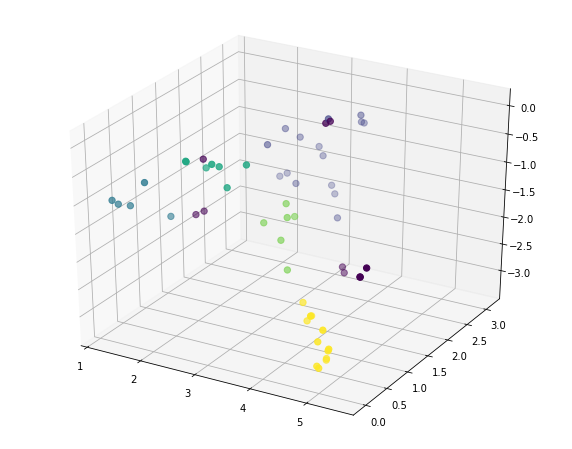

In [22]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(embedding[:,0], embedding[:,1], embedding[:,2], s=40, c=clusterer.labels_)

In [23]:
reducer = umap.UMAP(random_state=42,
                    n_components = 50, # Must be less than num samples
                    n_neighbors=3,
                    min_dist=0)
embedding_50 = reducer.fit_transform(pipeline.lrp_results)

min_cluster_sizes=range(3,20,1)
scores = pipeline.clusterPerf(embedding_50, [], min_cluster_sizes)
minsize = int(scores["Halkidi-Filtered Noise"].idxmin())
print("Minsize:", minsize)
scores["Halkidi-Filtered Noise"][minsize]

Minsize: 3


0.38538395708351236

In [24]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=minsize)
clusterer.fit(embedding_50)
pd.Series(clusterer.labels_).value_counts()

 3    20
 1    13
-1    10
 2     7
 0     5
dtype: int64